## Installs

## Imports

In [ ]:
!git clone https://github.com/ntasfi/PyGame-Learning-Environment
!pip install gym_ple
!pip install -e ./PyGame-Learning-Environment
!pip install pyvirtualdisplay
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev

fatal: destination path 'PyGame-Learning-Environment' already exists and is not an empty directory.
ERROR: Operation cancelled by user


In [ ]:
import sys
sys.path.append('/content/PyGame-Learning-Environment')
from ple.games.flappybird import FlappyBird
from ple import PLE
from gym import spaces
import IPython
import numpy as np
import gym
import os
import pyvirtualdisplay
import base64
import warnings
import imageio
from abc import ABC, abstractmethod
warnings.filterwarnings("ignore")


## Utility function to display episode

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Environment

### Environment Summary

This environment simulates the *Flappy Bird* game, where the agent controls the bird’s vertical position to navigate through gaps in pipes. Built on OpenAI’s `gym.Env` class, the environment allows interaction through standard functions like `step`, `reset`, and `render`.

**Key Components**

- **Observation Space**: The observation space includes 8 integer values, each representing a different aspect of the game state. These include:
  - `"player_y"`: The bird's vertical position.
  - `"player_vel"`: The bird's vertical velocity.
  - `"next_pipe_dist_to_player"`: Horizontal distance to the next pipe.
  - Additional features: Positions of the top and bottom of the next two pipes, enabling the agent to anticipate upcoming gaps.

- **Action Space**: This is a discrete space with two actions:
  - `0`: No flap (bird falls due to gravity).
  - `1`: Flap (bird moves upward).
- **Using the Environment**

  - **Step:**
    The `step` function returns four parameters: `obs`, `reward`, `done`, and `info`.

    - **`obs`**: The new observation after applying the action.
    - **`reward`**: The reward received for the action.
    - **`done`**: A boolean indicating whether the episode has ended.
    - **`info`**: A dictionary containing additional information. In this environment, the `info` dictionary includes a `"score"` entry that indicates how many pipes the bird has passed since the beginning of the episode.
  - **Reset**
    The `reset` function restores the environment to its initial state and returns the observation of that state.

  - **Render**
    The `render` function returns an image of the current state as a NumPy array (`np.array`).

  See the `Running the environment` section below for an example of how to use it.

- **Customizable Parameters**:
  - **`pipe_gap`**: This controls the vertical gap between pipes. The default is set to `80`, providing a moderate challenge.
  - **`custom_obs`** and **`custome_observation_map`**: Setting `custom_obs=True` instructs the environment to use a custom `observation_map` specified by the user, rather than the default map. When using a custom observation map, the user must also provide a `preprocess` function compatible with the custom observation map to ensure the observations are correctly processed for the agent.

  - **`preprocess`** and **`reward_shaping`**: Optional functions that allow the user to customize how observations and rewards are modified. The `preprocess` function transforms the raw observations according to the specified `observation_map`, while `reward_shaping` allows for custom adjustments to the reward structure, helping to align the environment with the agent’s learning goals.

  See the `Custom observation and reward shaping example of usage` section below for an example of usage.






In [ ]:
# to disable the python game window popup
os.environ["SDL_VIDEODRIVER"] = "dummy"

OBSERVATION_MAP = {0: 'player_y',
                   1: "player_vel",
                   2: "next_pipe_dist_to_player",
                   3: "next_pipe_top_y",
                   4: "next_pipe_bottom_y",
                   5: "next_next_pipe_dist_to_player",
                   6: "next_next_pipe_top_y",
                   7: "next_next_pipe_bottom_y",
}

class Game(gym.Env):
    def __init__(self, display_screen=False,
                 force_fps=True,
                 custom_obs=False,
                 pipe_gap=65,
                 custome_observation_map={},
                 preprocess=lambda x: x,
                 reward_shaping=lambda x, y, z: x):

        os.environ["SDL_VIDEODRIVER"] = "dummy"
        game = FlappyBird(pipe_gap=pipe_gap)  # define and initiate the environment
        self.env = PLE(game, fps=30, display_screen=display_screen,
                       force_fps=force_fps)
        self.env.init()
        # list of actions in the environment
        self.actions = self.env.getActionSet()
        # length of actions
        self.action_space = spaces.Discrete(len(self.actions))
        self.custom_obs = custom_obs
        self._observation_map = custome_observation_map if custom_obs else OBSERVATION_MAP
        self.preprocess = preprocess
        self.reward_shaping = reward_shaping
        self.score = 0

    @property
    def observation_space(self):
        return spaces.Box(low=0, high=512, shape=(len(self._observation_map),), dtype=int)

    def _get_rgb(self):
        return self.env.getScreenRGB().transpose(1, 0, 2)

    @property
    def observation_map(self):
        return self._observation_map

    def step(self, action):
        """Take the action chosen and update the reward"""
        reward = self.env.act(self.actions[action])
        if reward < 0:
          reward = -1

        if reward > 0:
          self.score += 1
        state = self.env.getGameState()
        terminal = self.env.game_over()
        reward = self.reward_shaping(reward, terminal, env)
        info = {'score':self.score}
        return self.preprocess(np.array(list(state.values())).astype(int)), reward, terminal, info

    def getGameState(self):
        '''
        PLEenv return gamestate as a dictionary. Returns a modified form
        of the gamestate only with the required information to define the state
        '''
        state = self.env.getGameState()
        h_dist = state['next_pipe_dist_to_player']
        next_pipe_bottom_y = state['next_pipe_bottom_y']
        next_pipe_top_y = state['next_pipe_top_y']
        vel = state['player_vel']
        player_y = state['player_y']
        next_next_pipe_bottom_y = state['next_next_pipe_bottom_y']
        next_next_pipe_top_y = state['next_next_pipe_top_y']

        return ' '.join([str(h_dist), str(next_pipe_bottom_y), str(next_pipe_top_y), str(vel), str(player_y), str(next_next_pipe_bottom_y), str(next_next_pipe_top_y)])

    def reset(self):
        """Resets the game to start a new game"""
        self.env.reset_game()
        state = self.env.getGameState()
        self.score = 0
        return self.preprocess(np.array(list(state.values())).astype(int))

    def render(self, mode='human'):
        """Render the game"""
        return self._get_rgb()

    def seed(self, seed):
        rng = np.random.RandomState(seed)
        self.env.rng = rng
        self.env.game.rng = self.env.rng

        self.env.init()

In [ ]:
env = Game(custom_obs=False)

### Observation space

In [ ]:
print(f"observation space: {env.observation_space}")
for feaure, des in env.observation_map.items():
  print(f"feaure: {feaure} -> {des}")

In this *Flappy Bird* environment, the `Box` type represents a `Discrete` observation space in OpenAI's Gym, providing the agent with a range of values in each dimension of the environment. Here’s what each part means:

* **Box**: This type of space is used to define a `Discrete`  range of values for each observation dimension. Here, it represents an 8-dimensional vector.
* **(0, 512)**: Each dimension within this space can take values from 0 to 512, which corresponds to the pixel boundaries of the game.
* **(8,)**: This shape indicates that there are 8 distinct variables in the observation vector, each capturing a critical feature of the environment.
* **int64**: Each value in the vector is an integer of 64-bit precision.

In summary, `Box(0, 512, (8,), int64)` represents an 8-dimensional vector space where each element is an integer from 0 to 512. Each dimension corresponds to a specific aspect of the *Flappy Bird* environment:

1. **Player Y Position**: The vertical position of the bird, representing its height on the screen.
2. **Player Velocity**: The bird’s current velocity, which impacts its movement and helps determine when to flap.
3. **Distance to Next Pipe**: The horizontal distance between the bird and the next pipe, crucial for timing flaps.
4. **Next Pipe Top Y Position**: The vertical position of the top of the next pipe, helping the bird gauge the gap.
5. **Next Pipe Bottom Y Position**: The vertical position of the bottom of the next pipe, providing further data for navigating the gap.
6. **Distance to Next-Next Pipe**: The horizontal distance to the pipe after the next one, giving the bird foresight into upcoming obstacles.
7. **Next-Next Pipe Top Y Position**: The vertical position of the top of the pipe after the next one, extending the bird's view of upcoming gaps.
8. **Next-Next Pipe Bottom Y Position**: The vertical position of the bottom of the pipe after the next one, for additional planning.

Together, these dimensions offer the agent a detailed snapshot of the environment, helping it make decisions based on its position, velocity, and the layout of both current and upcoming obstacles.


### Action space

In [ ]:
env.action_space

In this *Flappy Bird* environment, the `Discrete(2)` action space defines the possible actions the agent can take, using a finite set of discrete values:

* **Discrete**: This type of space is used when there are a limited number of distinct actions.
* **2**: The number of actions available, represented by values 0 and 1.

For *Flappy Bird*, these actions correspond to:
  * **0**: Do nothing (the bird continues to fall due to gravity).
  * **1**: Flap (the bird moves upward briefly).

In summary, `Discrete(2)` defines an action space with two possible actions: allowing the bird to either continue falling or flap to move upward, which is essential for navigating the gaps between pipes.


### Rewards

*Reward Structure:*



*   **Positive Reward**: For each pipe successfully passed, the agent receives a reward of **+1**.
*   **Negative Reward**: Upon reaching any terminal state, the agent receives a penalty of **-1**.
*   **Zero Reward**: Any other senario the reward is **0**




### Running the environmen

In [ ]:
env = Game()
env.seed(42)
obs = env.reset()
video_filename = '/content/vid.mp4'
max_steps = 100
# Evaluation
with imageio.get_writer(video_filename, fps=24) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = env.action_space.sample()
      obs, reward, done, info = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      total_reward += reward
      re = env.render()
      video.append_data(re)
      if done:
        score = info['score']
        print("Sum of rewards =", total_reward, ", Number of steps=", step, "score: ", score)
        break
embed_mp4(video_filename)

### Custom observation and reward shaping example of usage

In [ ]:
custom_obs_mapping = {0: "average",
                      1: 'sum'}

# meaningless preprocess method that average and sums all of the original features
preprocess = lambda x: np.array([np.mean(x), np.sum(x)])

# meaningless reward shaping method that added 1 to each original reward
reward_shaping = lambda x, y, z: x+1

env = Game(custom_obs=True,
           custome_observation_map=custom_obs_mapping,
           preprocess=preprocess,
           reward_shaping=reward_shaping)
env.seed(42)
obs = env.reset()

print(f"observation space: {env.observation_space}")
for feaure, des in env.observation_map.items():
  print(f"feaure: {feaure} -> {des}")

print(f"reset: {obs}")
print("#"*100, end="\n\n")
video_filename = '/content/vid.mp4'
max_steps = 100
# Evaluation
with imageio.get_writer(video_filename, fps=24) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = env.action_space.sample()
      obs, reward, done, info = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      total_reward += reward
      re = env.render()
      video.append_data(re)
      if done:
        score = info['score']
        print("Sum of rewards =", total_reward, ", Number of steps=", step, "score: ", score)
        break
embed_mp4(video_filename)

# Your Work begins here

## Implementation of Learning Agents

Abstract Class for Implementing an On-Policy Agent

Below is an abstract class to serve as a foundation for implementing an on-policy agent. Derive your agent from this class and implement the specific logic for your agent. Note that different agents may require additional parameters or functions to support their unique features and learning mechanisms.


In [ ]:
from abc import ABC, abstractmethod

class OnPolicyAgent(ABC):
    def __init__(self, action_space, observation_space, gamma, learning_rate):
        """
        Initializes the on-policy RL agent.
        You can add more parameters
        Parameters:
        - action_space: The action space of the environment
        - observation_space: The observation space of the environment
        - gamma: Discount factor for future rewards
        - learning_rate: Learning rate for policy updates
        """
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.policy = None  # Placeholder for policy (to be implemented in subclasses)

    @abstractmethod
    def select_action(self, observation, deterministic=False):
        """
        Select an action based on the current policy.

        Parameters:
        - observation: Current state observation from the environment
        -deterministic: Flag indicating whether to use a deterministic policy (default is False)
        Returns:
        - action: Chosen action based on the policy
        """
        pass

    @abstractmethod
    def update_policy(self, transition):
        """
        Update the policy based on the current transition.

        Parameters:
        - transition: Data collected from interactions with the environment (tuple of zero or more values such as acion, reward etc...)
        """
        pass

    @abstractmethod
    def train(self, env, num_episodes, log_every):
        """
        Train the agent over a specified number of episodes.

        Parameters:
        - env: The environment to train in
        - num_episodes: Number of training episodes
        """
        pass

    @abstractmethod
    def save_policy(self, file_path):
        """
        Save the current policy to a file.

        Parameters:
        - file_path: Path to the file where the policy should be saved
        """
        pass

    @abstractmethod
    def load_policy(self, file_path):
        """
        Load a policy from a file.

        Parameters:
        - file_path: Path to the file from which the policy should be loaded
        """
        pass

    @abstractmethod
    def run_policy(self, env):
        """
        Run the loaded policy in the environment for one episode.

        Parameters:
        - env: The environment in which to run the policy

        Returns:
        - total_reward: Total reward accumulated in the episode
        """
        pass


In [ ]:
class SarsaAgent(OnPolicyAgent):
    def __init__(self, action_space, observation_space, gamma, learning_rate, learning_rate_decay_rate, epsilon, epsilon_decay_rate, min_epsilon, bin_config):
        """
        Initializes the SARSA Agent with a 2D Q-table and custom observation space.
        """
        super().__init__(action_space, observation_space, gamma, learning_rate)
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.bin_config = bin_config

        # Calculate the total number of discrete states based on custom_obs shape
        self.obs_shape = observation_space.shape[0]
        self.num_states = np.prod(list(bin_config.values()))
        self.q_table = np.zeros((self.num_states, action_space.n))  # Initialize Q-table
        self.q_table_tracker = np.copy(self.q_table)
        print(f"Q-Table initialized: {self.q_table.shape[0]} states x {self.q_table.shape[1]} actions")


    def _get_custom_state_index(self, custom_obs):
        """
        Maps the custom_obs array to a unique discrete state index based on bin_config.

        Parameters:
        - custom_obs: The custom observation array to be mapped.

        Returns:
        - A unique discrete state index.
        """
        # Map each observation value to its respective bin index
        state_indices = [int(val) for val in custom_obs]

        # Convert multi-dimensional indices into a single discrete state index
        return np.ravel_multi_index(state_indices, list(self.bin_config.values()))


    def select_action(self, custom_obs, deterministic=False):
        """
        Select an action using epsilon-greedy strategy.
        """
        state_index = self._get_custom_state_index(custom_obs)

        if deterministic:
            return np.argmax(self.q_table[state_index])

        # Epsilon-greedy strategy
        if np.random.rand() < self.epsilon:
            action = self.action_space.sample()  # Random exploration
        else:
            action = np.argmax(self.q_table[state_index])  # Exploit

        # Decay epsilon after selecting an action
        self.decay_epsilon()

        return action

    def decay_epsilon(self):
        """
        Decay the epsilon value after each action selection.
        """
        self.epsilon = max(self.min_epsilon, self.epsilon * (1 - self.epsilon_decay_rate))

    def update_policy(self, transition):
        state, action, reward, next_state, next_action = transition
        target = reward + self.gamma * self.q_table[next_state][next_action]
        self.q_table[state][action] += self.learning_rate * (target - self.q_table[state][action])

    def train(self, env, num_episodes, log_every):
        """
        Train the SARSA agent in the environment using preprocessed observations.

        Parameters:
        - env: The environment to train in.
        - num_episodes: Total number of training episodes.
        - log_every: Frequency of logging in episodes.
        """
        pipes_per_episode = []  # Track pipes passed in each episode
        rewards_per_episode = []  # Track total rewards in each episode
        high_score_episodes = []  # Track episodes with high scores

        for episode in range(num_episodes):
            custom_obs = env.reset()  # Get the preprocessed initial observation
            state = self._get_custom_state_index(custom_obs)  # Get the state index
            action = self.select_action(custom_obs)
            pipes_passed = 0  # Track pipes passed in the current episode
            episode_reward = 0  # Track total reward in the current episode
            done = False

            while not done:
                custom_next_obs, reward, done, info = env.step(action)
                next_state = self._get_custom_state_index(custom_next_obs)  # Get the next state index
                next_action = self.select_action(custom_next_obs)

                # Update the policy
                self.update_policy((state, action, reward, next_state, next_action))

                # Update the current state and action
                state, action = next_state, next_action

                # Update episode reward and pipes passed
                episode_reward += reward
                pipes_passed = info.get("score", pipes_passed)

            # Log performance
            pipes_per_episode.append(pipes_passed)
            rewards_per_episode.append(episode_reward)
            high_score_episodes.append(pipes_passed >= 10)

            if (episode + 1) % log_every == 0:
                # Calculate metrics
                recent_high_scores = high_score_episodes[-log_every:]
                high_score_percentage = (sum(recent_high_scores) / log_every) * 100
                recent_pipes = pipes_per_episode[-log_every:]
                avg_pipes_passed = sum(recent_pipes) / len(recent_pipes)

                print(f"Episode {episode + 1}/{num_episodes}: "
                      f"Pipes Passed = {pipes_passed}, "
                      f"Reward = {episode_reward:.2f}, "
                      f"High Score Percentage (last {log_every}): {high_score_percentage:.2f}%, "
                      f"Average Pipes Passed (last {log_every}): {avg_pipes_passed:.2f}")

        return pipes_per_episode


    def save_policy(self, file_path):
        np.save(file_path, self.q_table)

    def load_policy(self, file_path):
        self.q_table = np.load(file_path)

    def run_policy(self, env):
        """
        Evaluate the policy on the environment.
        """
        custom_obs = env.reset()
        state = self._get_custom_state_index(custom_obs)
        done = False
        total_reward = 0
        pipes_passed = 0

        while not done:
            action = self.select_action(custom_obs, deterministic=True)
            custom_obs, reward, done, info = env.step(action)
            total_reward += reward
            pipes_passed = info.get("score", pipes_passed)

        return total_reward, pipes_passed

In [ ]:
class QLearningAgent(OnPolicyAgent):
    def __init__(self, action_space, observation_space, gamma, learning_rate, learning_rate_decay_rate, epsilon, epsilon_decay_rate, min_epsilon, bin_config):
        """
        Initializes the QLearning Agent with a 2D Q-table and custom observation space.
        """
        super().__init__(action_space, observation_space, gamma, learning_rate)
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.bin_config = bin_config

        # Calculate the total number of discrete states based on custom_obs shape
        self.obs_shape = observation_space.shape[0]
        self.num_states = np.prod(list(bin_config.values()))
        self.q_table = np.zeros((self.num_states, action_space.n))  # Initialize Q-table
        self.q_table_tracker = np.copy(self.q_table)
        print(f"Q-Table initialized: {self.q_table.shape[0]} states x {self.q_table.shape[1]} actions")


    def _get_custom_state_index(self, custom_obs):
        """
        Maps the custom_obs array to a unique discrete state index based on bin_config.

        Parameters:
        - custom_obs: The custom observation array to be mapped.

        Returns:
        - A unique discrete state index.
        """
        # Map each observation value to its respective bin index
        state_indices = [int(val) for val in custom_obs]

        # Convert multi-dimensional indices into a single discrete state index
        return np.ravel_multi_index(state_indices, list(self.bin_config.values()))




    def select_action(self, state_index, deterministic=False):
        """
        Select an action using epsilon-greedy strategy.
        """

        if deterministic:
            return np.argmax(self.q_table[state_index])

        # Epsilon-greedy strategy
        if np.random.rand() < self.epsilon:
            action = self.action_space.sample()  # Random exploration
        else:
            action = np.argmax(self.q_table[state_index])  # Exploit

        # Decay epsilon after selecting an action
        self.decay_epsilon()

        return action

    def decay_epsilon(self):
        """
        Decay the epsilon value after each action selection.
        """
        self.epsilon = max(self.min_epsilon, self.epsilon * (1 - self.epsilon_decay_rate))

    def update_policy(self, transition):
        state, action, reward, next_state = transition
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate * (target - self.q_table[state][action])
        self.q_table_tracker[state][action] += 1

    def train(self, env, num_episodes, log_every):
        """
        Train the QLearning Agent in the environment using preprocessed observations.

        Parameters:
        - env: The environment to train in.
        - num_episodes: Total number of training episodes.
        - log_every: Frequency of logging in episodes.
        """
        pipes_per_episode = []  # Track pipes passed in each episode
        rewards_per_episode = []  # Track total rewards in each episode
        high_score_episodes = []  # Track episodes with high scores

        for episode in range(num_episodes):
            custom_obs = env.reset()  # Get the preprocessed initial observation
            state = self._get_custom_state_index(custom_obs)  # Get the state index
            action = self.select_action(state)
            pipes_passed = 0  # Track pipes passed in the current episode
            episode_reward = 0  # Track total reward in the current episode
            done = False

            while not done:
                custom_next_obs, reward, done, info = env.step(action)
                next_state = self._get_custom_state_index(custom_next_obs)  # Get the next state index

                # Update the policy
                self.update_policy((state, action, reward, next_state))

                # Update the current state and action
                state = next_state
                action = self.select_action(state)

                # Update episode reward and pipes passed
                episode_reward += reward
                pipes_passed = info.get("score", pipes_passed)

            # Log performance
            pipes_per_episode.append(pipes_passed)
            rewards_per_episode.append(episode_reward)
            high_score_episodes.append(pipes_passed >= 10)

            if (episode + 1) % log_every == 0:
                # Calculate metrics
                recent_high_scores = high_score_episodes[-log_every:]
                high_score_percentage = (sum(recent_high_scores) / log_every) * 100
                recent_pipes = pipes_per_episode[-log_every:]
                avg_pipes_passed = sum(recent_pipes) / len(recent_pipes)

                print(f"Episode {episode + 1}/{num_episodes}: "
                      f"Pipes Passed = {pipes_passed}, "
                      f"Reward = {episode_reward:.2f}, "
                      f"High Score Percentage (last {log_every}): {high_score_percentage:.2f}%, "
                      f"Average Pipes Passed (last {log_every}): {avg_pipes_passed:.2f}")

        return pipes_per_episode, rewards_per_episode


    def save_policy(self, file_path):
        np.save(file_path, self.q_table)

    def load_policy(self, file_path):
        self.q_table = np.load(file_path)

    def run_policy(self, env):
        """
        Evaluate the policy on the environment.
        """
        custom_obs = env.reset()
        done = False
        total_reward = 0
        pipes_passed = 0

        while not done:
            state = self._get_custom_state_index(custom_obs)
            action = self.select_action(state, deterministic=True)
            custom_obs, reward, done, info = env.step(action)
            total_reward += reward
            pipes_passed = info.get("score", pipes_passed)

        return total_reward, pipes_passed

## Training

#### Experimentation Instructions

In this section, you will conduct a series of experiments to solve the environment using your on-policy agent. Follow these guidelines for a clear and comprehensive presentation of your work:

1. **Design and Run Experiments**:
   - Perform at least **5 distinct experiments** with your agent, including:
     - **2 unsuccessful experiments** where the agent fails to learn the environment (reaching a score below the target).
     - **1 successful experiment** where the agent achieves a score of **10** or higher. (Remember the score is define by the amount of pipes the agent has passed)

   - *Note*: In practice, you are expected to try many configurations to observe various outcomes, even beyond these 3 experiments.

2. **Provide Detailed Summaries**:
   - For each experiment, include:
     - **Graphs** that illustrate the training process, such as reward progression, steps, score, and  any other relevant metrics (there is many more metrics that we can learn from).
     - **Explanations of Hyperparameters**: Clearly describe the configuration of hyperparameters chosen for each experiment, and the reasoning behind these choices.
     - **Preprocessing and Reward Shaping**: Explain any data preprocessing or reward shaping techniques applied, along with the motivation for these techniques.

3. **Analyze and Reflect**:
   - **Result Analysis**: Analyze each experiment's outcome, focusing on why the agent may have succeeded or failed based on your configurations.
   - **Insights and Deductions**: Draw insights from each experiment, noting what worked and what didn’t. Use these insights to refine your understanding of the environment and agent performance.

4. **Final Report**:
   - **Synthesize Findings**: Compile all observations, insights, and analysis from your experiments into a final report. This report should showcase your learnings and demonstrate a deep understanding of the experimentation process.
   - **Emphasis on Analysis**: The analysis of your results and the conclusions drawn are the most critical aspects of this exercise. Dedicate ample attention to this section, as it will reflect your ability to interpret and understand the agent’s learning process.

**Remember**: The goal of this exercise is to experiment, learn, and iterate. Document your process thoroughly, as this will form the foundation of your report.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_update_heatmap(update_counts):
    """
    Plot a heatmap to visualize how many times each cell was updated.

    Parameters:
    - update_counts: 2D array where each cell indicates the number of updates.
    """
    plt.figure(figsize=(6, 15))  # Adjust size for better clarity

    # Plot the heatmap with explicit range
    plt.imshow(update_counts, cmap="viridis", aspect="auto", vmin=0, vmax=10)
    cbar = plt.colorbar(label="Number of Updates")

    # Add axis labels and ticks
    plt.title("Heatmap of Cell Updates", fontsize=16)
    plt.xlabel("Actions", fontsize=14)
    plt.ylabel("States", fontsize=14)
    plt.xticks(ticks=[0, 1], labels=["0", "1"], fontsize=12)  # Binary actions
    plt.yticks(fontsize=12)

    # Remove grid and adjust layout
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def analyze_and_plot(pipes_per_episode, reward_per_episode):
    """
    Analyze and plot performance metrics based on episodes_pipes and episodes_rewards.

    Parameters:
    - episodes_pipes: List of scores (pipes passed) in each episode.
    - episodes_rewards: List of rewards in each episode.
    """
    num_episodes = len(pipes_per_episode)
    episodes = np.arange(1, num_episodes + 1)

    # Calculate averages every 100 episodes
    avg_pipes_100 = [np.mean(pipes_per_episode[i:i+100]) for i in range(0, num_episodes, 100)]
    avg_rewards_100 = [np.mean(reward_per_episode[i:i+100]) for i in range(0, num_episodes, 100)]

    # Calculate the percentage of episodes with score > 10
    high_score_percentage = (np.sum(np.array(pipes_per_episode) > 10) / num_episodes) * 100

    # Create a map of average reward according to score
    score_reward_map = {}
    for score, reward in zip(pipes_per_episode, reward_per_episode):
        if score not in score_reward_map:
            score_reward_map[score] = []
        score_reward_map[score].append(reward)

    avg_reward_per_score = {score: np.mean(rewards) for score, rewards in score_reward_map.items()}

    # Sort the map for better visualization
    sorted_scores = sorted(avg_reward_per_score.keys())
    sorted_avg_rewards = [avg_reward_per_score[score] for score in sorted_scores]

    # Plot 1: Average score every 100 episodes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(avg_pipes_100) + 1), avg_pipes_100, marker='o', label='Average Score (100 episodes)')
    plt.title('Average Score Every 100 Episodes')
    plt.xlabel('Batch (100 Episodes)')
    plt.ylabel('Average Score')
    plt.grid()
    plt.legend()
    plt.show()

    # Plot 2: Average reward every 100 episodes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(avg_rewards_100) + 1), avg_rewards_100, marker='o', label='Average Reward (100 episodes)', color='orange')
    plt.title('Average Reward Every 100 Episodes')
    plt.xlabel('Batch (100 Episodes)')
    plt.ylabel('Average Reward')
    plt.grid()
    plt.legend()
    plt.show()

    # Plot 3: Map of average reward according to score
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_scores, sorted_avg_rewards, color='green', label='Avg Reward per Score')
    plt.title('Average Reward According to Score')
    plt.xlabel('Score')
    plt.ylabel('Average Reward')
    plt.grid(axis='y')
    plt.legend()
    plt.show()

    # Print percentage of episodes with score > 10
    print(f"Percentage of episodes with a score higher than 10: {high_score_percentage:.2f}%")

def plot_percentage_scores_above_threshold(scores, threshold=10, window=100):
    """
    Plot the percentage of scores above a given threshold in every specified window of episodes.

    Parameters:
    - scores: List of scores for each training episode.
    - threshold: The score threshold to consider (default is 10).
    - window: The number of episodes in each window (default is 100).
    """
    num_episodes = len(scores)

    # Calculate the percentage of scores above the threshold for every window
    percentages = [
        (np.sum(np.array(scores[i:i + window]) > threshold) / window) * 100
        for i in range(0, num_episodes, window)
    ]

    # Plot the graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(percentages) + 1), percentages, marker='o', label=f'Percentage > {threshold}')
    plt.title(f'Percentage of Scores Above {threshold} in Every {window} Episodes', fontsize=16)
    plt.xlabel('Window (100 Episodes)', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


Experiment One:
Q - learning:
Exlanation of hyperparameters:    
This was one of our first experiments, and we chose these hyperparameters after manual experimentation (trial and error). We wanted to see if they allow us to evaluate other parts of our agent well. Our process for testing different configurations was first identfying effective preprocess and reward shaping methods, and later fine-tuning the hyperparameters. We put an emphasis on our Epsilon and Epsilon decay rate choices, as these are extremly correlated to the number of training episodes. We tried to find an Epsilon that will hold a significant value (over min_epsilon configuration) for at least 1/4 of the training, as we felt that this will be a susbstantial amount of exploration. We chose a min_epsilon value according to examples we saw online and our estimation of what would be an effective min_epsilon, as this was at the very beggining of our learning process.
we gradually grew the number of training episodes until we reached 15,000 as shown below, where we saw or agent's learning plateau, and therefore decided to try a different approach.

Explanation of preprocess:
We divided each parameter into a predefined number of bins as follows:
1. next_pipe_dist_to_player_bin (horizantal distance from next pipe) into 25 bins
2. next_pipe_bottom_y_minus_player_y_bin (player position in regards to next pipe gap) into 50 bins
3. next_next_pipe_bottom_y_minus_player_y_bin (player position in regards to next-next pipe gap) into 50 bins
4. player_vel_bin (player velocity) into 10 bins

We began our training by trying to identify the parameters we think are relevant to the bird when trying to decide what action to choose.

- Distance from the next pipe: crucial to decide when the bird should be at a proper height to pass through the next pipe

- Distance from next pipe gap: crucial to know what height to adjust to

- Distance from next next pipe gap: will help the bird identify the proper height from which to exit the next pipe in order to pass the next next pipe successfully

- Velocity:
crucial to predict the effects of each action on the birds flight, and to know the effects of the previous actions

We initially chose the number of bins according to an eye test, to get a feel for the enviroment.

Explanation of reward shaping:
We hypothesized that just by identfying which behaviours lead to the ending of an episode, that our agent would be able to optimize its behviour to prolong games as much as possible. THerefore chose to leave reward shaping untouched.This hypothesis turned to be false almost immediately.

In [ ]:
custome_observation_map = {
    0: "next_pipe_dist_to_player_bin",
    1: "next_pipe_bottom_y_minus_player_y_bin",
    2: "next_next_pipe_bottom_y_minus_player_y_bin",
    3: "player_vel_bin"
}  # Assign each feature a description of its meaning

def preprocess(obs):
    """
    Preprocess the observation into discrete bins:
    - `next_pipe_dist_to_player` into 20 equal bins in [0, 288].
    - `next_pipe_bottom_y - player_y` into 50 equal bins in [-512, 512].
    - `player_vel` into 5 equal bins in [-8, 10].
    """

    # Extract the required values from the observation
    next_pipe_dist_to_player = obs[2]  # Horizontal distance
    next_pipe_bottom_y_minus_player_y = obs[4] - obs[0]  # Vertical distance from next pipe
    next_next_pipe_bottom_y_minus_player_y = obs[5] - obs[0] # Vertical distance from next next pipe
    player_vel = obs[1]  # Player velocity

    # Bin next_pipe_dist_to_player into 20 equal bins
    if next_pipe_dist_to_player <= 0:
        next_pipe_dist_to_player_bin = 0  # Bin 0: out of range (too close)
    elif next_pipe_dist_to_player >= 288:
        next_pipe_dist_to_player_bin = 19  # Bin 19: maximum range
    else:
        bin_width = 288 / 20  # 20 bins in range [0, 288]
        next_pipe_dist_to_player_bin = int(next_pipe_dist_to_player // bin_width)

    # Bin next_pipe_bottom_y_minus_player_y into 50 equal bins
    if next_pipe_bottom_y_minus_player_y <= -512:
        next_pipe_bottom_y_minus_player_y_bin = 0  # Bin 0: below minimum
    elif next_pipe_bottom_y_minus_player_y >= 512:
        next_pipe_bottom_y_minus_player_y_bin = 49  # Bin 49: above maximum
    else:
        bin_width = 1024 / 50  # 50 bins in range [-512, 512]
        next_pipe_bottom_y_minus_player_y_bin = int(
            (next_pipe_bottom_y_minus_player_y + 512) // bin_width
        )

    # Bin next_pipe_bottom_y_minus_player_y into 50 equal bins
    if next_next_pipe_bottom_y_minus_player_y <= -512:
        next_next_pipe_bottom_y_minus_player_y_bin = 0  # Bin 0: below minimum
    elif next_next_pipe_bottom_y_minus_player_y >= 512:
        next_next_pipe_bottom_y_minus_player_y_bin = 49  # Bin 49: above maximum
    else:
        bin_width = 1024 / 50  # 50 bins in range [-512, 512]
        next_next_pipe_bottom_y_minus_player_y_bin = int(
            (next_next_pipe_bottom_y_minus_player_y + 512) // bin_width
        )

    # Bin player_vel into 5 equal bins in range [-8, 10]
    if player_vel <= -8:
        player_vel_bin = 0  # Bin 0: minimum velocity
    elif player_vel >= 10:
        player_vel_bin = 4  # Bin 4: maximum velocity
    else:
        bin_width = (10 - (-8)) / 5  # Bin width for 5 bins in range [-8, 10]
        player_vel_bin = int((player_vel - (-8)) // bin_width)

    # Combine processed values into a numpy array
    processed_array = np.array([
        next_pipe_dist_to_player_bin,
        next_pipe_bottom_y_minus_player_y_bin,
        next_next_pipe_bottom_y_minus_player_y_bin,
        player_vel_bin
    ])

    return processed_array


In [ ]:
def reward_shaping(reward, terminal, env):
    """
    Reward shaping function.
    """

    return reward

In [ ]:
# Initialize the Game environment
env = Game(
    custom_obs=True,
    preprocess=preprocess,
    reward_shaping=reward_shaping,
    custome_observation_map=custome_observation_map
)
obs = env.reset

# Define the bin configuration
bin_config = {
    0: 25,   # 25 bins for the first feature
    1: 50,   # 50 bins for the second feature
    2: 50,   # 50 bins for the third feature
    3: 10    # 10 bins for fourth feature
}

# Initialize QLearning Agent
Q_agent = QLearningAgent(
    action_space=env.action_space,
    observation_space=env.observation_space,
    gamma=0.99,
    learning_rate=0.1,
    learning_rate_decay_rate=0.000,
    epsilon=0.1,
    epsilon_decay_rate=0.001,
    min_epsilon=0.001,
    bin_config=bin_config
)

# Train the agent
num_episodes = 15000
log_every = 100
print("Training Q Agent...")
pipes_per_episode, reward_per_episode = Q_agent.train(env, num_episodes, log_every)

# Save the policy
Q_agent.save_policy("QLearning_policy.npy")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

analyze_and_plot(pipes_per_episode, reward_per_episode)
plot_update_heatmap(Q_agent.q_table_tracker)

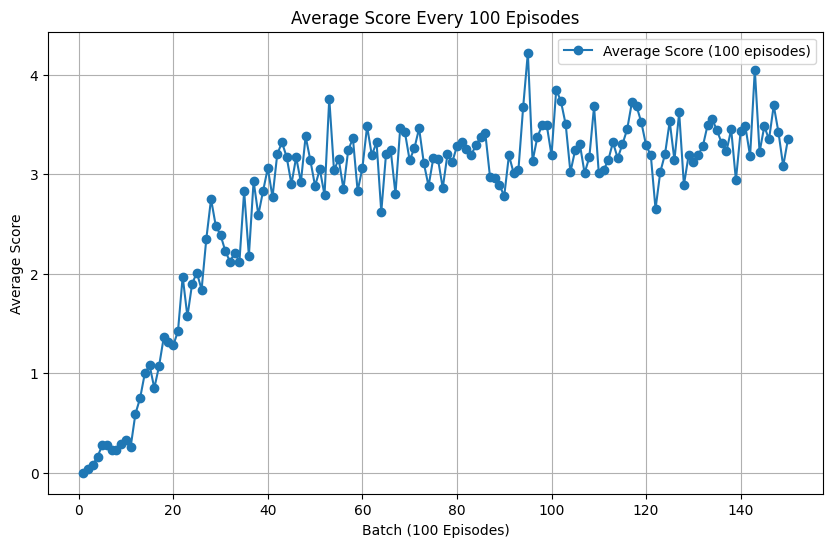

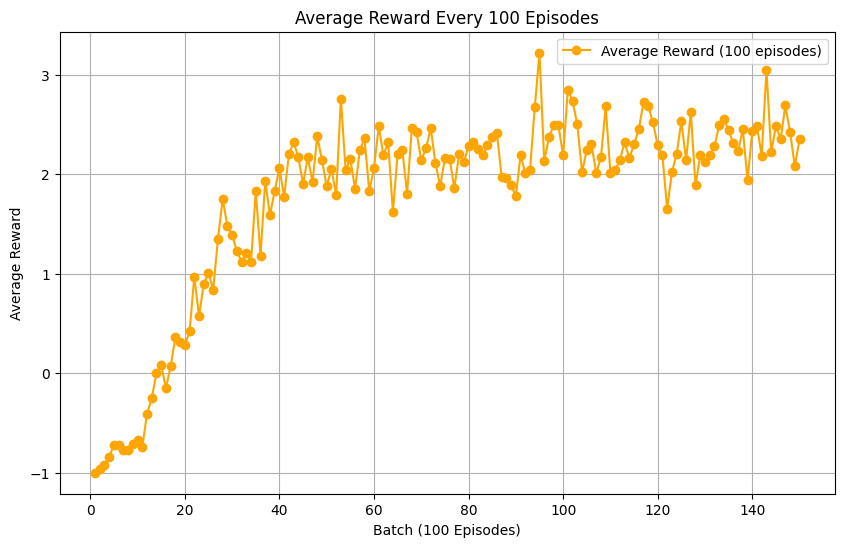

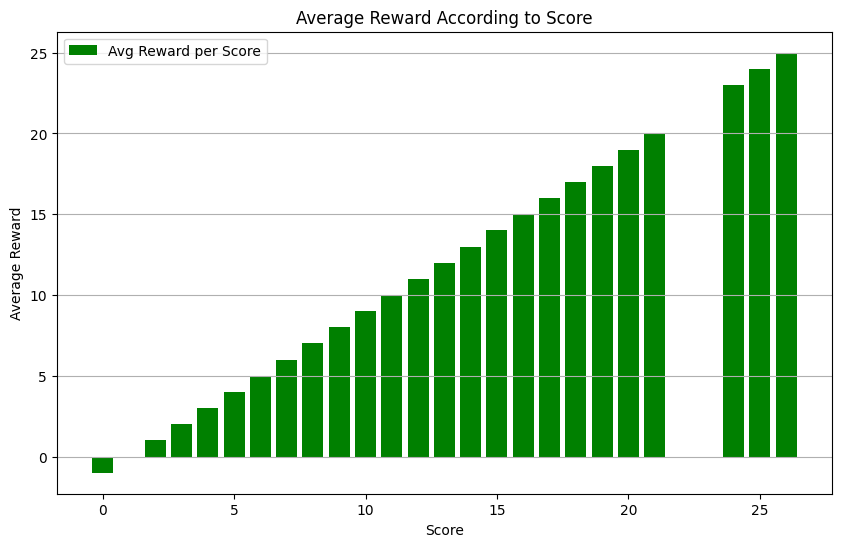

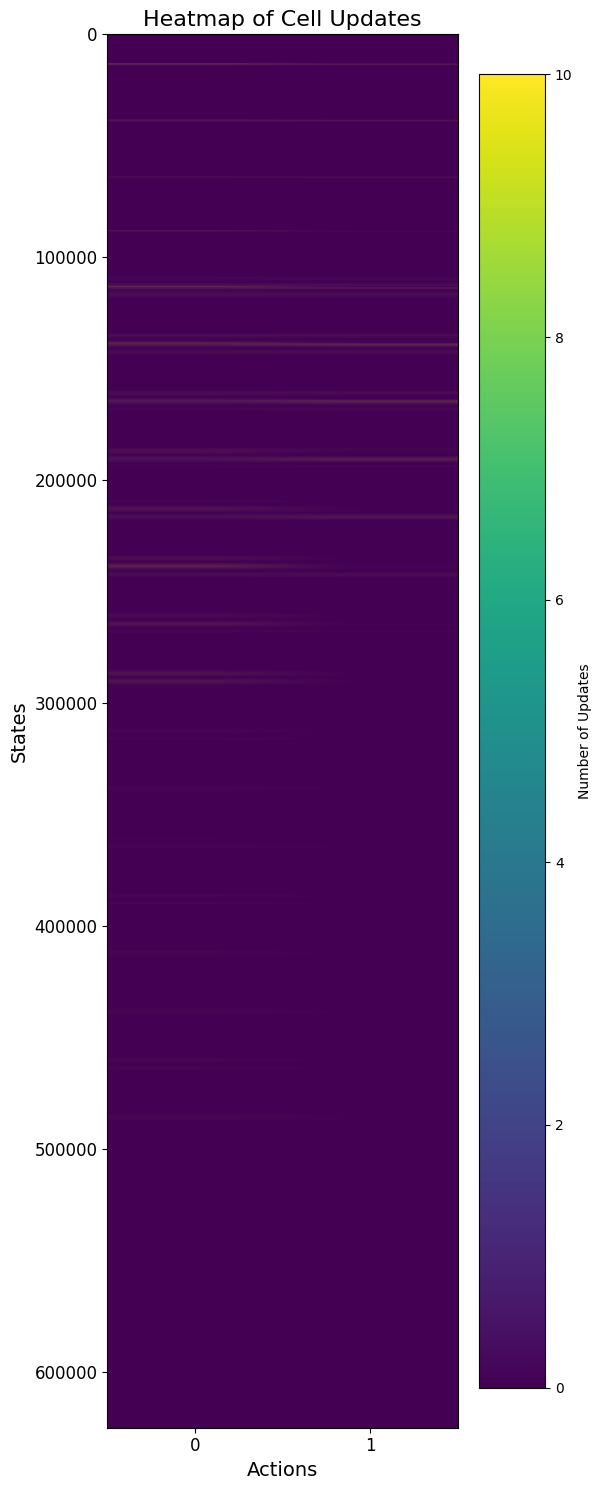

*Analysis and Reflection*  

The average score achieved with this configuration was understandably very low. The most revealing insight from this experiment came from the heat map, which showed the number of entries into each cell of the Q-table. This visualization made it clear that the Q-table was excessively large, hindering an effective learning process. Most states were never accessed during training, indicating their redundancy. Following this experiment, we began exploring methods to downsize the Q-table.  

Additionally, we observed that the average reward per score increased as the score grew. This suggests that the reward system was functioning as intended and did not confuse the agent.


*Experiment Two: Explanation of Hyperparameters*  

To gain a deeper understanding of the learning process, we minimized the changes between experiments. In this experiment, we adjusted only the *Epsilon* parameter to encourage more exploration. We hypothesized that the agent’s tendency to end runs prematurely could be due to insufficient exploration—failing to discover the pipes and the rewards available by progressing further.  

*Preprocessing*  
We divided each parameter into predefined bins as follows:  
- *next_pipe_dist_to_player_bin* (horizontal distance from the next pipe): 25 bins  
- *next_pipe_bottom_y_minus_player_y_bin* (player's vertical position relative to the next pipe gap): 50 bins  
- *player_vel_bin* (player velocity): 10 bins  

After analyzing Experiment 1, we determined it was necessary to significantly reduce the size of the Q-table. To achieve this, we removed the *next_next_pipe_bottom_y_minus_player_y_bin* parameter, as it was deemed the least important. This reduction downsized the Q-table from *625,000 states × 2 actions* to *5,000 states × 2 actions*.  

*Reward Shaping*  
We retained the original reward shaping to focus solely on the impact of the Q-table size reduction and better assess its effects.  




In [ ]:
custome_observation_map = {
    0: "next_pipe_dist_to_player_bin",
    1: "next_pipe_bottom_y_minus_player_y_bin",
    2: "player_vel_bin"
}  # Assign each feature a description of its meaning

def preprocess(obs):
    """
    Preprocess the observation into discrete bins:
    - `next_pipe_dist_to_player` into 20 equal bins in [0, 288].
    - `next_pipe_bottom_y - player_y` into 50 equal bins in [-512, 512].
    - `player_vel` into 5 equal bins in [-8, 10].
    """

    # Extract the required values from the observation
    next_pipe_dist_to_player = obs[2]  # Horizontal distance
    next_pipe_bottom_y_minus_player_y = obs[4] - obs[0]  # Vertical distance from next pipe
    player_vel = obs[1]  # Player velocity

    # Bin next_pipe_dist_to_player into 10 equal bins
    if next_pipe_dist_to_player <= 0:
        next_pipe_dist_to_player_bin = 0  # Bin 0: out of range (too close)
    elif next_pipe_dist_to_player >= 288:
        next_pipe_dist_to_player_bin = 9  # Bin 19: maximum range
    else:
        bin_width = 288 / 10  # 10 bins in range [0, 288]
        next_pipe_dist_to_player_bin = int(next_pipe_dist_to_player // bin_width)

    # Bin next_pipe_bottom_y_minus_player_y into 25 equal bins
    if next_pipe_bottom_y_minus_player_y <= -512:
        next_pipe_bottom_y_minus_player_y_bin = 0  # Bin 0: below minimum
    elif next_pipe_bottom_y_minus_player_y >= 512:
        next_pipe_bottom_y_minus_player_y_bin = 24  # Bin 49: above maximum
    else:
        bin_width = 1024 / 25  # 25 bins in range [-512, 512]
        next_pipe_bottom_y_minus_player_y_bin = int(
            (next_pipe_bottom_y_minus_player_y + 512) // bin_width
        )

    # Bin player_vel into 10 equal bins in range [-8, 10]
    if player_vel <= -8:
        player_vel_bin = 0  # Bin 0: minimum velocity
    elif player_vel >= 10:
        player_vel_bin = 9  # Bin 4: maximum velocity
    else:
        bin_width = (10 - (-8)) / 10  # Bin width for 5 bins in range [-8, 10]
        player_vel_bin = int((player_vel - (-8)) // bin_width)

    # Combine processed values into a numpy array
    processed_array = np.array([
        next_pipe_dist_to_player_bin,
        next_pipe_bottom_y_minus_player_y_bin,
        player_vel_bin
    ])

    return processed_array

In [ ]:
def reward_shaping(reward, terminal, env):
    """
    Reward shaping function.
    """

    return reward


In [ ]:
# Initialize the Game environment
env = Game(
    custom_obs=True,
    preprocess=preprocess,
    reward_shaping=reward_shaping,
    custome_observation_map=custome_observation_map
)
obs = env.reset

# Define the bin configuration
bin_config = {
    0: 10,  # 10 bins for the first feature
    1: 25,  # 25 bins for the second feature
    2: 10   # 10 bins for third feature
}

# Initialize SARSA Agent
Q_agent = QLearningAgent(
    action_space=env.action_space,
    observation_space=env.observation_space,
    gamma=0.99,
    learning_rate=0.1,
    learning_rate_decay_rate=0.000,
    epsilon=0.15,
    epsilon_decay_rate=0.001,
    min_epsilon=0.001,
    bin_config=bin_config
)

# Train the agent
num_episodes = 10000
log_every = 100
print("Training Q Agent...")
pipes_per_episode, reward_per_episode = Q_agent.train(env, num_episodes, log_every)

# Save the policy
Q_agent.save_policy("QLearning_policy.npy")

In [ ]:
analyze_and_plot(pipes_per_episode, reward_per_episode)
plot_update_heatmap(Q_agent.q_table_tracker)
def print_qtable_with_custom_labels(q_table, bin_config, custom_observation_map):
    """
    Unravel state numbers in a Q-table and print the corresponding observations
    with custom labels alongside their Q-values for each action.

    Parameters:
    - q_table: 2D array where each row represents a state, and the columns are Q-values for actions.
    - bin_config: A dictionary specifying the number of bins for each observation dimension.
    - custom_observation_map: A dictionary mapping observation indices to descriptive labels.
    """
    # Create observation labels based on the custom observation map
    observation_labels = [
        custom_observation_map.get(i, f"Feature {i}") for i in range(len(bin_config))
    ]

    print("Q-Table with Unraveled States:")
    print("-" * 80)

    for state_number, q_values in enumerate(q_table):
        # Unravel the state number into observation bin indices
        obs_bin_indices = np.unravel_index(state_number, list(bin_config.values()))
        obs_bin_indices = list(obs_bin_indices)

        # Print the unraveled observation and Q-values
        obs_string = ", ".join(f"{label}: {value}" for label, value in zip(observation_labels, obs_bin_indices))
        q_values_string = ", ".join(f"Action {i+1}: {q_value:.2f}" for i, q_value in enumerate(q_values))
        print(f"State {state_number} -> {obs_string} | {q_values_string}")

print_qtable_with_custom_labels(Q_agent.q_table_tracker, bin_config, custome_observation_map)


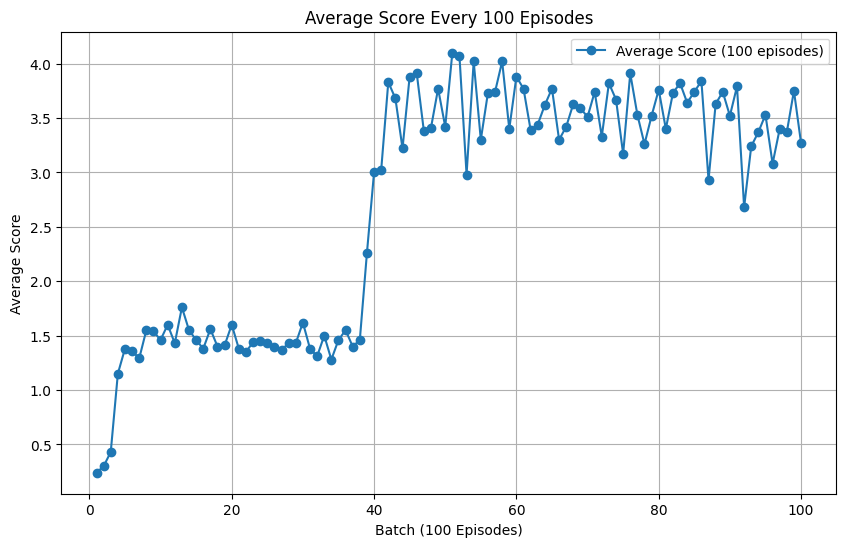

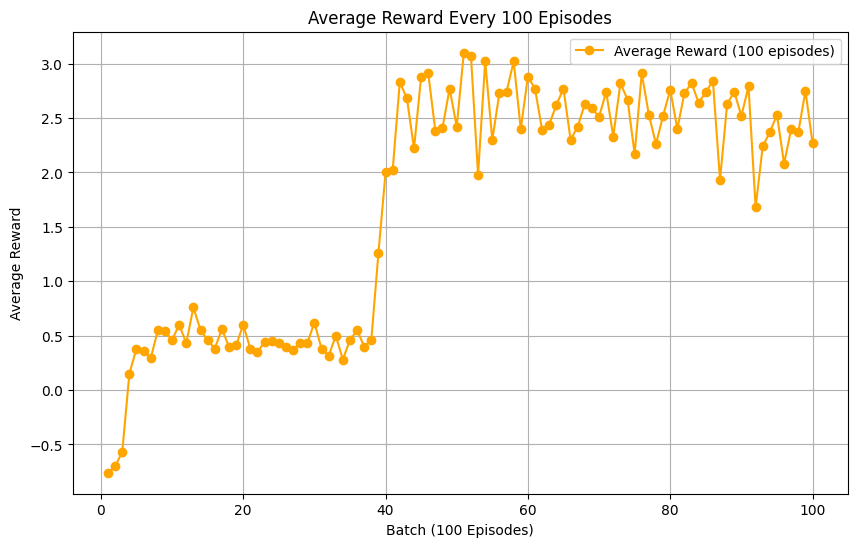

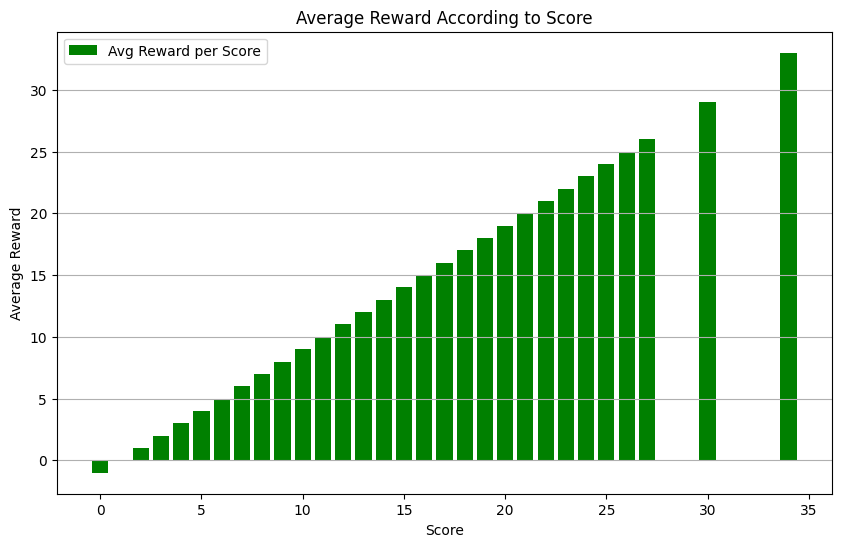

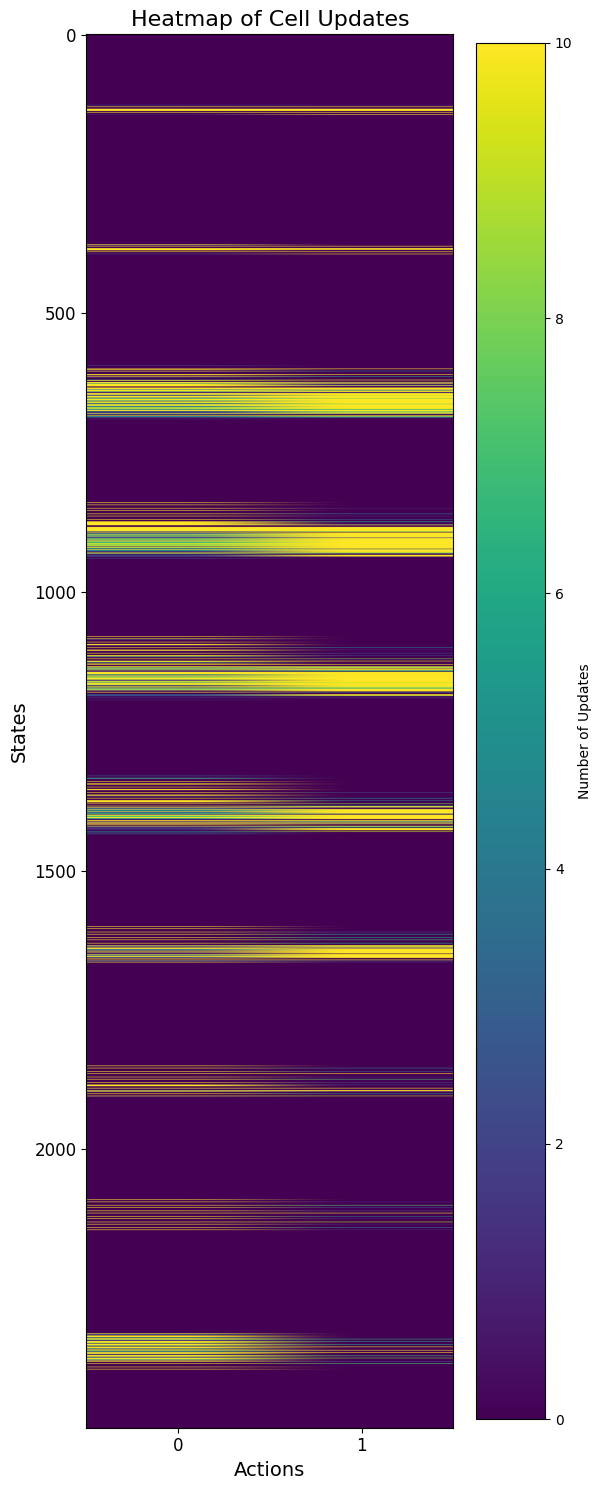

*Analysis*  
The results show that the average reward per score increases as the score grows, indicating that the reward system is functioning correctly and does not confuse the agent.  

Additionally, the reduction in Q-table size had no effect on the results, which supports our hypothesis that the initial Q-table in the first experiment contained an excessive number of states. Despite the significant reduction in states, many of them remained unused. This observation prompted us to investigate which states represented irrelevant scenarios.  

To identify these unused states, we "unraveled" the state numbers. We found that these states corresponded to scenarios where the player was in undesirable positions, such as:  
- A very large horizontal distance from the next pipe.  
- A very large vertical distance from the pipe gap.  

This analysis led us to realize that these irrelevant states could be grouped together without losing important insights into the player's position. By clumping these states, we could further reduce the Q-table size while retaining the critical information required for the agent's decision-making process.

*Experiment Three*  

*Explanation of Hyperparameters*  

The hyperparameters used in Experiment 3 are identical to those in Experiment 2. After extensive trial and error, as well as consulting with peers and online resources, we concluded that these hyperparameters are appropriate and effective for this experiment.


*Preprocessing Explanation*  
Before designing this preprocessing method, we identified a common desirable action for a wide range of vertical distances between the player's position (*player_y*) and the pipe gap. Specifically:  
- When the bird is above the pipe gap, the optimal action is always to descend (choosing *action 0*).  
- When the bird is below the pipe gap, the optimal action is always to ascend (choosing *action 1*).  

This observation allowed us to group all such states into a single state, as the desirable action remains consistent. This significantly reduced the size of the Q-table, simplifying the learning process for the agent.  

The only position that required further discrimination was when the player was situated between the two pipes. To address this, we created five additional states to refine the distinction within this region. Additionally, we decided to remove the horizontal distance parameter from the Q-table. This decision was based on our observation that proper reward shaping could guide the bird into the desired position (between the pipes) long before horizontal distance became a critical factor. This further simplified the Q-table.  

*Reward Shaping Explanation*  
We provided positive rewards to the agent for positioning itself between the next two pipes, which represents the desired behavior. This precise identification of the target behavior allowed us to reward the agent appropriately, shaping how it learns to play the game.  

To balance the reward system, we chose values that would not overshadow the reward for passing a pipe or the penalty for crashing. Specifically:  
- A reward of *0.05* was given for every step the player remained in the desired zone (between the two pipes).  
- A penalty of *-0.05* was applied for every step the player was outside the desired zone.

In [ ]:
custome_observation_map = {
    0 : "player_y_bin_next_pipe",
    1 : "player_vel_bin",
} # assing each action with a description of the feature meaning
def preprocess(obs):
    """
    Preprocesses the observation dictionary into a numpy array.

    - Maps `player_y` into 10 bins relative to `next_pipe_top_y` and `next_pipe_bottom_y`.
    - Maps `player_y` into 10 bins relative to `next_next_pipe_top_y` and `next_next_pipe_bottom_y`.
    - Bins `player_vel` into 10 bins over the range [-8, 10].
    - Returns a numpy array of the transformed values.
    """
    # Extract required values from the observation
    player_y = obs[0]
    player_vel = obs[1]
    next_pipe_top_y = obs[3]
    next_pipe_bottom_y = obs[4]

    # Bin player_y relative to next_pipe
    if next_pipe_bottom_y > player_y > next_pipe_top_y:
        # Divide the middle range into 5 bins
        bin_size = (next_pipe_bottom_y - next_pipe_top_y) / 5
        player_y_bin_next_pipe = int((player_y - next_pipe_top_y) / bin_size) + 1  # Bins 1–5
    elif player_y <= next_pipe_top_y:
        player_y_bin_next_pipe = 0  # Bin 0: below the top pipe
    else:  # player_y >= next_pipe_bottom_y
        player_y_bin_next_pipe = 6  # Bin 6: above the bottom pipe

    # Bin player_vel into 10 equal bins over the range [-8, 10]
    bin_width = (10 - (-8)) / 10  # Bin width for 10 bins
    player_vel_bin = int((player_vel - (-8)) // bin_width)
    player_vel_bin = min(max(player_vel_bin, 0), 9)  # Ensure bin index is within [0, 9]

    # Combine processed values into a numpy array
    processed_array = np.array([
        player_y_bin_next_pipe,
        player_vel_bin
    ])
    # print(f"Processed Bins: {processed_array}")
    return processed_array

In [ ]:
def reward_shaping(reward, terminal, env):
    """
    Reward shaping function.
    """
    new_reward = reward
    if not terminal:
        # Parse the game state string returned by getGameState()
        state = env.getGameState()
        h_dist, next_pipe_bottom_y, next_pipe_top_y, vel, player_y, next_next_pipe_bottom_y, next_next_pipe_top_y = map(float, state.split())  # Extract state
        if next_next_pipe_bottom_y - 10 >= player_y >= next_next_pipe_top_y + 10:
          new_reward += 0.05
        else:
          new_reward -= 0.05

    return new_reward

In [ ]:
# Initialize the Game environment
env = Game(
    custom_obs=True,
    preprocess=preprocess,
    reward_shaping=reward_shaping,
    custome_observation_map=custome_observation_map
)
obs = env.reset

# Define the bin configuration
bin_config = {
    0: 7,  # 7 bins for the first feature
    1: 10,  # 10 bins for the second feature
}

# Initialize SARSA Agent
Q_agent = QLearningAgent(
    action_space=env.action_space,
    observation_space=env.observation_space,
    gamma=0.99,
    learning_rate=0.1,
    learning_rate_decay_rate=0.000,
    epsilon=0.15,
    epsilon_decay_rate=0.001,
    min_epsilon=0.001,
    bin_config=bin_config
)

# Train the agent
num_episodes = 2000
log_every = 100
print("Training Q Agent...")
pipes_per_episode, reward_per_episode = Q_agent.train(env, num_episodes, log_every)

# Save the policy
Q_agent.save_policy("QLearning_policy.npy")

In [ ]:
analyze_and_plot(pipes_per_episode, reward_per_episode)
plot_update_heatmap(Q_agent.q_table_tracker)
plot_percentage_scores_above_threshold(pipes_per_episode)

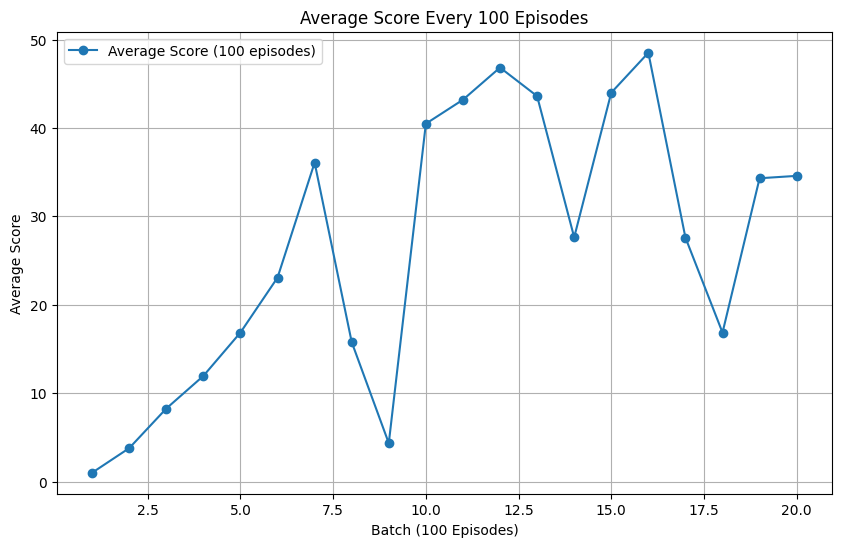

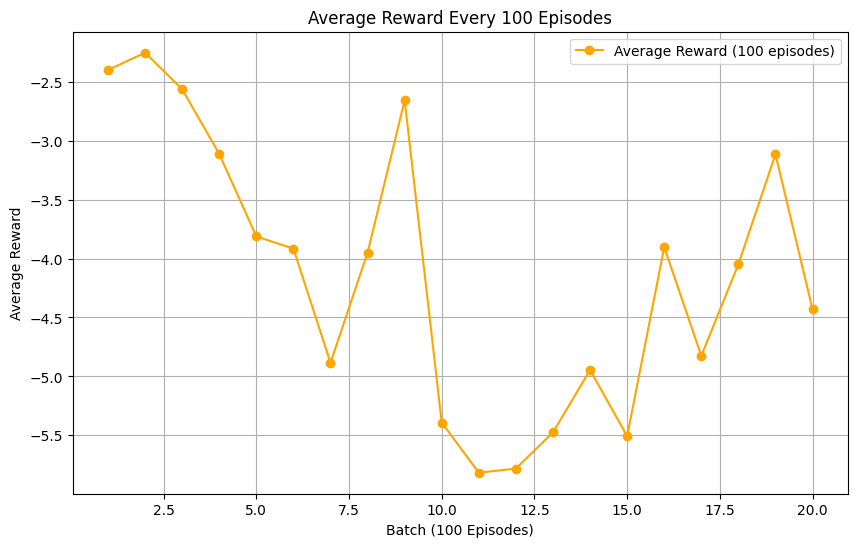

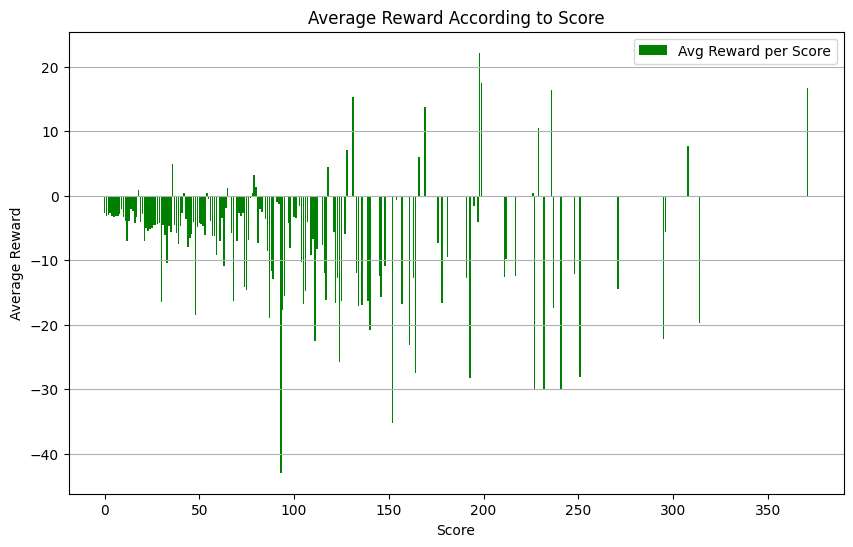

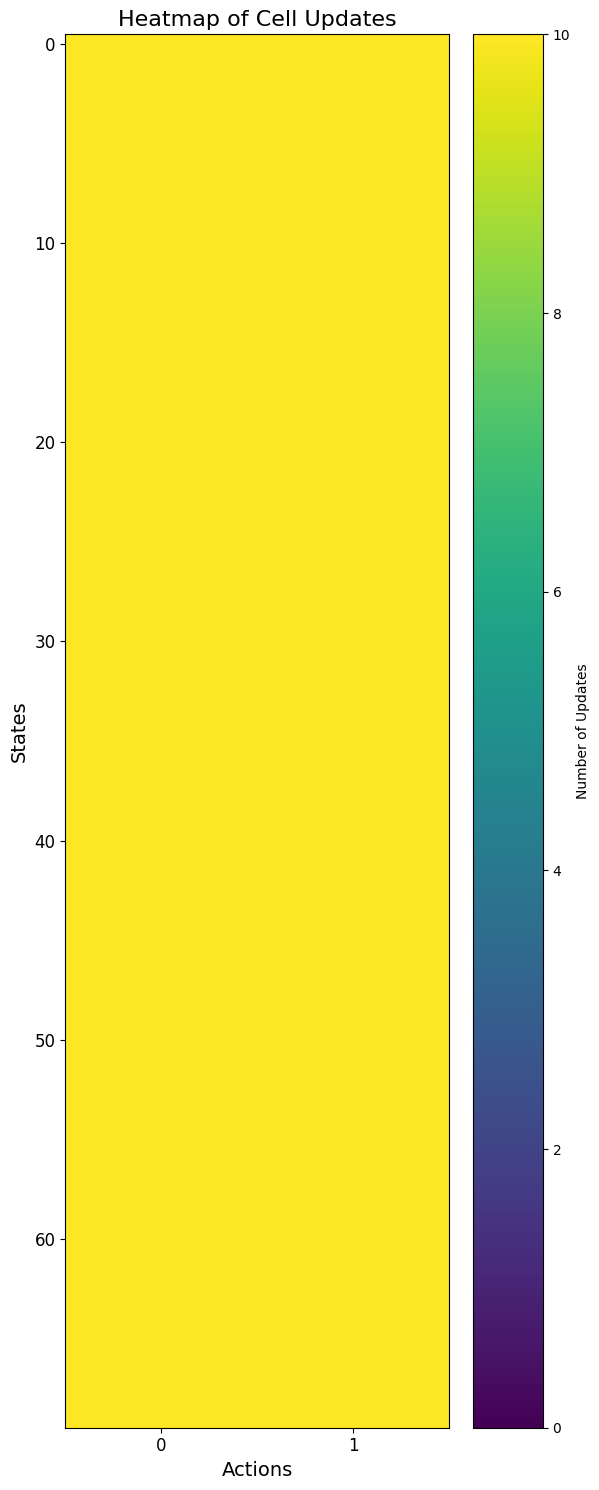

*Analysis of Experiment 3*  

We observed a significant increase in the average score, which we attribute to the use of a small number of highly descriptive states. The heat map shows that each state was accessed during training, indicating that the reduced Q-table effectively captured relevant scenarios.  

Additionally, the graph of the average score per 100 episodes displays an upward trend, suggesting that the model may not have been trained for enough episodes, as it had not yet reached its peak performance.  

However, the most concerning observation comes from the graph of average reward versus score. This graph shows that many high scores were associated with very low rewards. This indicates that the agent struggled to correctly identify and reward good behavior. This issue arises because the reward system did not adequately replace the horizontal distance to the next pipe parameter, leading to confusion for the agent.  

Overall, this approach of using a simplified Q-table shows significant potential. If we can refine the reward system further, the model's performance could improve substantially.

*Experiment Four*  
*Explanation of Hyperparameters*  

As with the transition from Experiment 2 to Experiment 3, we did not see a need to modify the hyperparameters for Experiment 4.

We chose to train the agent for *1,500 episodes*, as we observed no further improvement when running additional episodes.  

*Reward Shaping Explanation*  
After reviewing gameplay videos, we noticed that the agent reacted too slowly to the height of the next pipe. This delay was caused by the timing of the transition between the *next_pipe* and *next_next_pipe, which occurred after the agent ideally should have started reacting to the **next_next_pipe. To address this, we identified the horizontal distance from the **next_pipe* where the reward system should stop prioritizing the *next_pipe* and begin rewarding based on the *next_next_pipe*.  

*Preprocessing Explanation*  
To align with the reward shaping changes, we introduced additional discrimination for critical states where the horizontal distance is between *7* and *5*.  
- We chose this range because when the horizontal distance is *7, the player is still at risk of crashing into the **next_pipe, but when it is **5, the **next_pipe* is no longer a danger.  

We also added the vertical distance from the *next_next_pipe* to the state space for a similar reason: since the reward system is based on this distance, the agent needs well-defined states to associate these rewards with.  

The rest of the preprocessing remains identical to Experiment Three.

In [ ]:
custome_observation_map = {
    0 : "player_y_bin_next_pipe",
    1 : "player_y_bin_next_next_pipe",
    2 : "player_vel_bin",
    3 : "h_dist_bin"
} # assing each action with a description of the feature meaning
def preprocess(obs):
    """
    Preprocesses the observation dictionary into a numpy array.

    - Maps `player_y` into 7 bins relative to `next_pipe_top_y` and `next_pipe_bottom_y`.
    - Maps `player_y` into 7 bins relative to `next_next_pipe_top_y` and `next_next_pipe_bottom_y`.
    - Bins `player_vel` into 10 bins over the range [-8, 10].
    - Returns a numpy array of the transformed values.
    """
    # Extract required values from the observation
    player_y = obs[0]
    player_vel = obs[1]
    next_pipe_top_y = obs[3]
    next_pipe_bottom_y = obs[4]
    next_next_pipe_top_y = obs[6]
    next_next_pipe_bottom_y = obs[7]
    h_dist = obs[2]

    # print(f"player_y = {player_y}, "
    # f"player_vel = {player_vel}, "
    # f"next_pipe_top_y = {next_pipe_top_y}, "
    # f"next_pipe_bottom_y = {next_pipe_bottom_y}, "
    # f"next_next_pipe_top_y = {next_next_pipe_top_y}, "
    # f"next_next_pipe_bottom_y = {next_next_pipe_bottom_y}")

    # Bin player_y relative to next_pipe
    if next_pipe_bottom_y > player_y > next_pipe_top_y:
        # Divide the middle range into 7 bins
        bin_size = (next_pipe_bottom_y - next_pipe_top_y) / 5
        player_y_bin_next_pipe = int((player_y - next_pipe_top_y) / bin_size) + 1  # Bins 1–5
    elif player_y <= next_pipe_top_y:
        player_y_bin_next_pipe = 0  # Bin 0: below the top pipe
    else:  # player_y >= next_pipe_bottom_y
        player_y_bin_next_pipe = 6  # Bin 6: above the bottom pipe

    # Bin player_y relative to next_next_pipe
    if next_next_pipe_bottom_y > player_y > next_next_pipe_top_y:
        # Divide the middle range into 5 bins
        bin_size = (next_next_pipe_bottom_y - next_next_pipe_top_y) / 5
        player_y_bin_next_next_pipe = int((player_y - next_next_pipe_top_y) / bin_size) + 1  # Bins 1–5
    elif player_y <= next_next_pipe_top_y:
        player_y_bin_next_next_pipe = 0  # Bin 0: below the top pipe
    else:  # player_y >= next_next_pipe_bottom_y
        player_y_bin_next_next_pipe = 6  # Bin 6: above the bottom pipe

    # Bin player_vel into 10 equal bins over the range [-8, 10]
    bin_width = (10 - (-8)) / 10  # Bin width for 10 bins
    player_vel_bin = int((player_vel - (-8)) // bin_width)
    player_vel_bin = min(max(player_vel_bin, 0), 9)  # Ensure bin index is within [0, 9]

    #Bin h_dist to three bins
    if h_dist <= 5:
      h_dist_bin = 0
    elif 7 >= h_dist > 5:
      h_dist_bin = 1
    else:
      h_dist_bin = 2

    # Combine processed values into a numpy array
    processed_array = np.array([
        player_y_bin_next_pipe,
        player_y_bin_next_next_pipe,
        player_vel_bin,
        h_dist_bin
    ])
    # print(f"Processed Bins: {processed_array}")
    return processed_array



In [ ]:
def reward_shaping(reward, terminal, env):
    """
    Reward shaping function.
    """
    new_reward = reward

    if not terminal:
        # Parse the game state string returned by getGameState()
        state = env.getGameState()
        h_dist, next_pipe_bottom_y, next_pipe_top_y, vel, player_y, next_next_pipe_bottom_y, next_next_pipe_top_y = map(float, state.split())  # Extract state

        if h_dist <= 5:
          if next_next_pipe_bottom_y >= player_y >= next_next_pipe_top_y:
            new_reward += 0.5
          else:
            new_reward -= 0.5
        else:
          if next_pipe_bottom_y -20 >= player_y >= next_pipe_top_y + 20:
            new_reward += 0.5
          else:
            new_reward -= 0.5


    return new_reward

In [ ]:
# Initialize the Game environment
env = Game(
    custom_obs=True,
    preprocess=preprocess,
    reward_shaping=reward_shaping,
    custome_observation_map=custome_observation_map
)
obs = env.reset

# Define the bin configuration
bin_config = {
    0: 7,  # 7 bins for the first feature
    1: 7,  # 7 bins for the first feature
    2: 10, # 10 bins for the first feature
    3: 3   # 3 bins for the first feature
}

# Initialize SARSA Agent
Q_agent = QLearningAgent(
    action_space=env.action_space,
    observation_space=env.observation_space,
    gamma=0.99,
    learning_rate=0.1,
    learning_rate_decay_rate=0.000,
    epsilon=0.15,
    epsilon_decay_rate=0.001,
    min_epsilon=0.001,
    bin_config=bin_config
)

# Train the agent
num_episodes = 1500
log_every = 100
print("Training Q Agent...")
pipes_per_episode, reward_per_episode = Q_agent.train(env, num_episodes, log_every)

# Save the policy
Q_agent.save_policy("QLearning_policy.npy")

In [ ]:
analyze_and_plot(pipes_per_episode, reward_per_episode)
plot_update_heatmap(Q_agent.q_table_tracker)
plot_percentage_scores_above_threshold(pipes_per_episode)


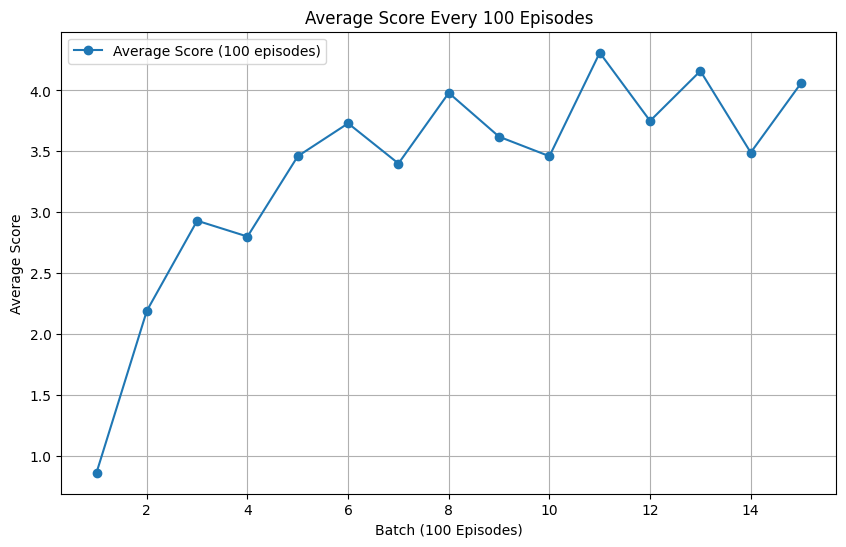

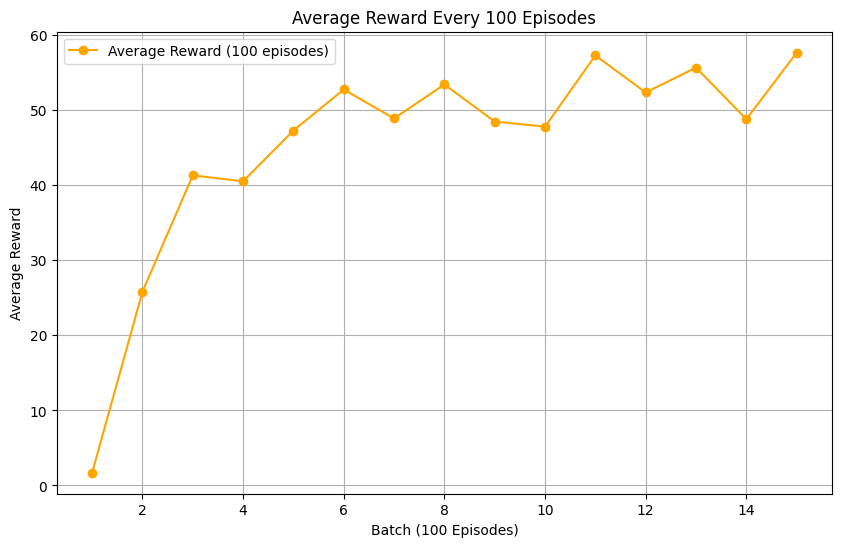

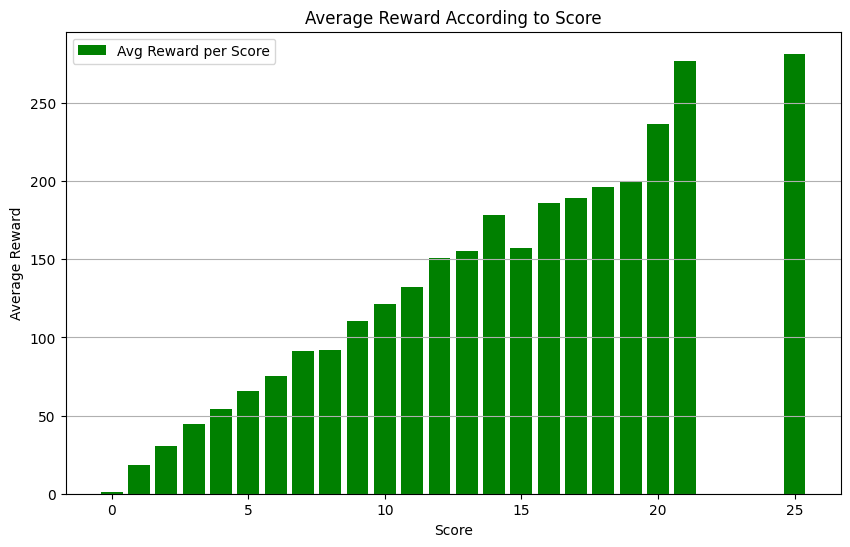

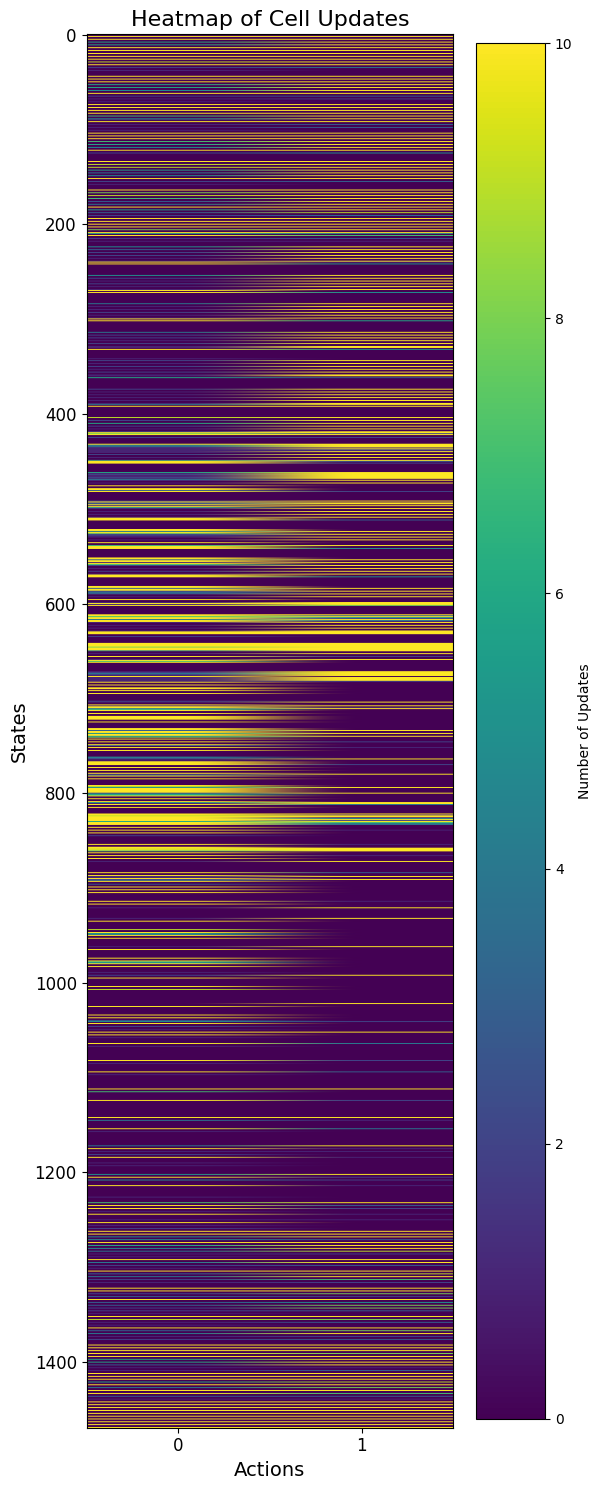

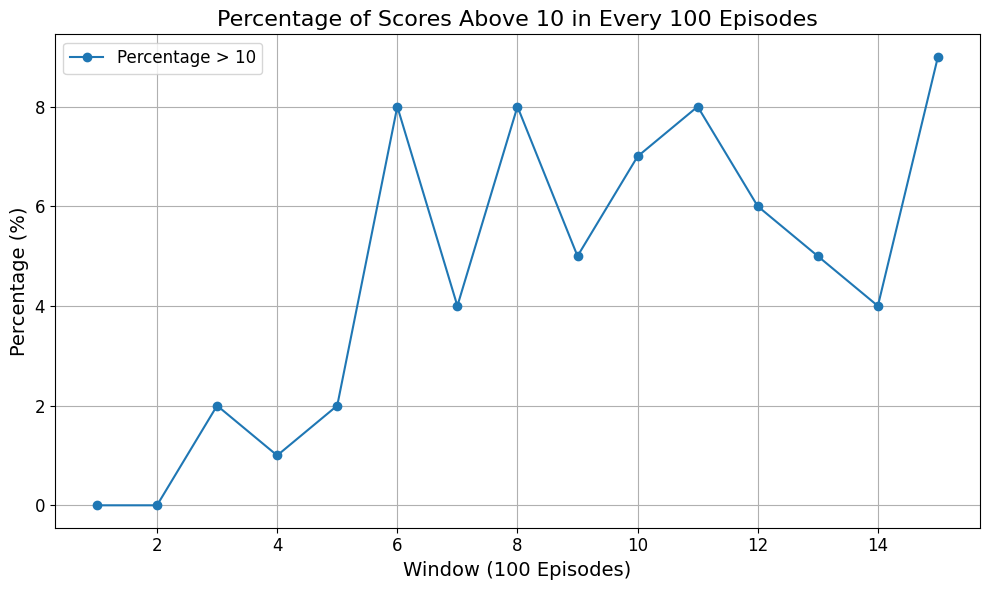

*Analysis*  

We observed that this model produced highly variable results with each training session. The results shown here represent a relatively poor training run for this model.  

One notable issue is that many states in the Q-table were not accessed during training, which is unusual given the Q-table's relatively small size. This led us to suspect that the agent was not exploring thoroughly, likely due to an insufficiently high *Epsilon* value. This lack of exploration results in erratic outcomes, as the agent’s early encounters with certain states heavily influence the overall training process.  

On a positive note, the reward per score shows a strong correlation—higher scores consistently result in higher rewards. However, the fact that many states were not reached, either for *action one* or *action two*, suggests that the number of training episodes may be insufficient for the agent to fully interact with all the states in the Q-table.

expierement five:
this experiment is identical to experiment four. This is a succesful run of our model opposed to the unsucesful experiment four.


In [ ]:
custome_observation_map = {
    0 : "player_y_bin_next_pipe",
    1 : "player_y_bin_next_next_pipe",
    2 : "player_vel_bin",
    3 : "h_dist_bin"
} # assing each action with a description of the feature meaning
def preprocess(obs):
    """
    Preprocesses the observation dictionary into a numpy array.

    - Maps `player_y` into 7 bins relative to `next_pipe_top_y` and `next_pipe_bottom_y`.
    - Maps `player_y` into 7 bins relative to `next_next_pipe_top_y` and `next_next_pipe_bottom_y`.
    - Bins `player_vel` into 10 bins over the range [-8, 10].
    - Returns a numpy array of the transformed values.
    """
    # Extract required values from the observation
    player_y = obs[0]
    player_vel = obs[1]
    next_pipe_top_y = obs[3]
    next_pipe_bottom_y = obs[4]
    next_next_pipe_top_y = obs[6]
    next_next_pipe_bottom_y = obs[7]
    h_dist = obs[2]

    # print(f"player_y = {player_y}, "
    # f"player_vel = {player_vel}, "
    # f"next_pipe_top_y = {next_pipe_top_y}, "
    # f"next_pipe_bottom_y = {next_pipe_bottom_y}, "
    # f"next_next_pipe_top_y = {next_next_pipe_top_y}, "
    # f"next_next_pipe_bottom_y = {next_next_pipe_bottom_y}")

    # Bin player_y relative to next_pipe
    if next_pipe_bottom_y > player_y > next_pipe_top_y:
        # Divide the middle range into 7 bins
        bin_size = (next_pipe_bottom_y - next_pipe_top_y) / 5
        player_y_bin_next_pipe = int((player_y - next_pipe_top_y) / bin_size) + 1  # Bins 1–5
    elif player_y <= next_pipe_top_y:
        player_y_bin_next_pipe = 0  # Bin 0: below the top pipe
    else:  # player_y >= next_pipe_bottom_y
        player_y_bin_next_pipe = 6  # Bin 6: above the bottom pipe

    # Bin player_y relative to next_next_pipe
    if next_next_pipe_bottom_y > player_y > next_next_pipe_top_y:
        # Divide the middle range into 5 bins
        bin_size = (next_next_pipe_bottom_y - next_next_pipe_top_y) / 5
        player_y_bin_next_next_pipe = int((player_y - next_next_pipe_top_y) / bin_size) + 1  # Bins 1–5
    elif player_y <= next_next_pipe_top_y:
        player_y_bin_next_next_pipe = 0  # Bin 0: below the top pipe
    else:  # player_y >= next_next_pipe_bottom_y
        player_y_bin_next_next_pipe = 6  # Bin 6: above the bottom pipe

    # Bin player_vel into 10 equal bins over the range [-8, 10]
    bin_width = (10 - (-8)) / 10  # Bin width for 10 bins
    player_vel_bin = int((player_vel - (-8)) // bin_width)
    player_vel_bin = min(max(player_vel_bin, 0), 9)  # Ensure bin index is within [0, 9]

    #Bin h_dist to three bins
    if h_dist <= 5:
      h_dist_bin = 0
    elif 7 >= h_dist > 5:
      h_dist_bin = 1
    else:
      h_dist_bin = 2

    # Combine processed values into a numpy array
    processed_array = np.array([
        player_y_bin_next_pipe,
        player_y_bin_next_next_pipe,
        player_vel_bin,
        h_dist_bin
    ])
    # print(f"Processed Bins: {processed_array}")
    return processed_array



In [ ]:
def reward_shaping(reward, terminal, env):
    """
    Reward shaping function.
    """
    new_reward = reward

    if not terminal:
        # Parse the game state string returned by getGameState()
        state = env.getGameState()
        h_dist, next_pipe_bottom_y, next_pipe_top_y, vel, player_y, next_next_pipe_bottom_y, next_next_pipe_top_y = map(float, state.split())  # Extract state
        # print(h_dist)
        if h_dist <= 5:
          if next_next_pipe_bottom_y >= player_y >= next_next_pipe_top_y:
            new_reward += 0.5
          else:
            new_reward -= 0.5
        else:
          if next_pipe_bottom_y -20 >= player_y >= next_pipe_top_y + 20:
            new_reward += 0.5
          else:
            new_reward -= 0.5


    return new_reward

In [ ]:
# Initialize the Game environment
env = Game(
    custom_obs=True,
    preprocess=preprocess,
    reward_shaping=reward_shaping,
    custome_observation_map=custome_observation_map
)
obs = env.reset

# Define the bin configuration
bin_config = {
    0: 7,  # 7 bins for the first feature
    1: 7,  # 7 bins for the first feature
    2: 10, # 10 bins for the first feature
    3: 3   # 3 bins for the first feature
}

# Initialize SARSA Agent
Q_agent = QLearningAgent(
    action_space=env.action_space,
    observation_space=env.observation_space,
    gamma=0.99,
    learning_rate=0.1,
    learning_rate_decay_rate=0.000,
    epsilon=0.15,
    epsilon_decay_rate=0.001,
    min_epsilon=0.001,
    bin_config=bin_config
)

# Train the agent
num_episodes = 1200
log_every = 100
print("Training Q Agent...")
pipes_per_episode, reward_per_episode = Q_agent.train(env, num_episodes, log_every)

# Save the policy
Q_agent.save_policy("QLearning_policy.npy")

In [ ]:
analyze_and_plot(pipes_per_episode, reward_per_episode)
plot_update_heatmap(Q_agent.q_table_tracker)
plot_percentage_scores_above_threshold(pipes_per_episode)

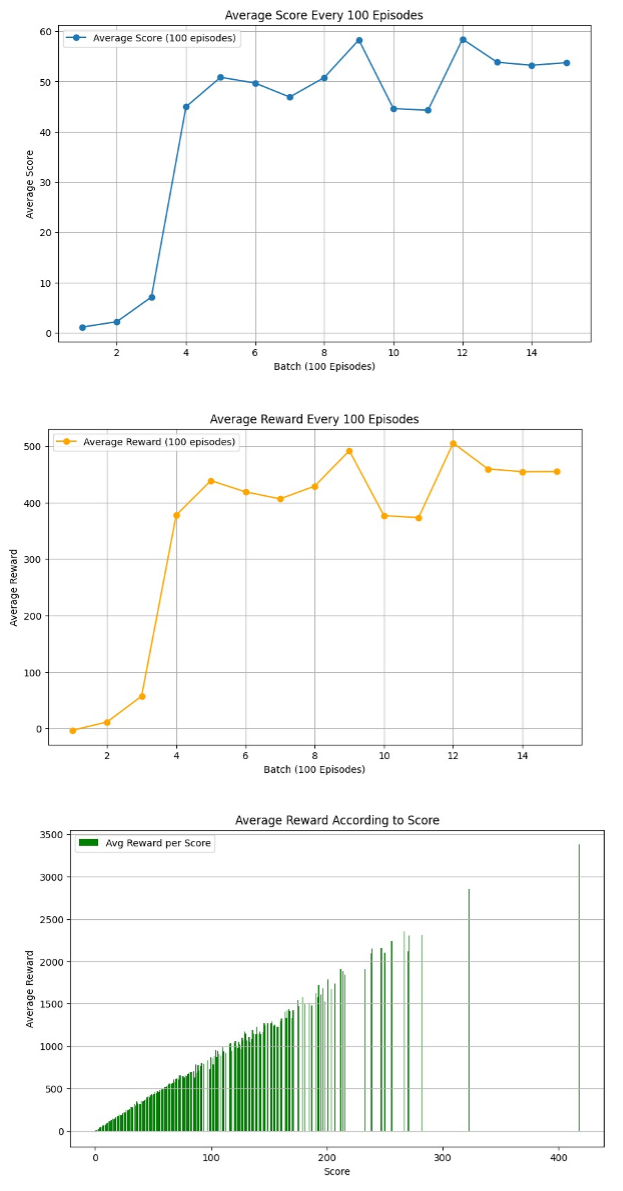

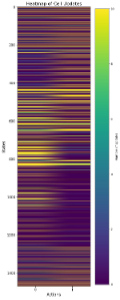

analysis of five:
This is one of our better training sessions. We can notice that the heatmap of this successful training session seems to be more explored than that of experiment 4, this is puzzling considiring our observation that changing epsilon and it's decay rate did not have much affect on the results of our traing sessions. We also can notice (this was a recurring trait) that a succesful training versus a unsuccesful training is decided in the first 400-500 episodes. Our hypothesis is that when episodes with certain traits appear early in the training session our model learns more effectively.

## Validation

#### Validation Section

In this section, you will validate your agent’s performance using the best-performing configuration identified in the experimentation phase. This validation step should be less exhaustive than the experimentation section but should provide sufficient evidence of your agent's consistency and stability.

1. **Run Validation Trials**:
   - Using the chosen configuration, run the agent in the environment for **multiple trials** (e.g., 5-10 episodes) to test its reliability.
   - Observe the agent's performance across these trials to confirm whether it consistently achieves or exceeds the target score of 10.

2. **Provide Key Summaries**:
   - **Performance Metrics**: Summarize the agent’s performance with key metrics such as average score, highest score, and variance across trials.
   - **Graphs** (Optional): Include basic graphs showing score progression or any other relevant metric, if they provide additional insight into the agent's stability.

3. **Brief Analysis**:
   - Reflect on the agent's performance in validation. Note any patterns or inconsistencies and provide a short explanation of how these results align (or differ) from your expectations based on the experimentation phase.

*Note*: This validation section should confirm and strengthen the results of your experimentation, focusing on reliability and consistency rather than extensive analysis.

*Note*: Store the agent's policy to files since you asked to provide aditional notbook that loads the agent policy


In [ ]:
"""
Insert you validation code here
"""
Q_agent = QLearningAgent(
    action_space=env.action_space,
    observation_space=env.observation_space,
    gamma=0.995,
    learning_rate=0.15,
    learning_rate_decay_rate=0.0004,
    epsilon=0.1,
    epsilon_decay_rate=0.01,
    min_epsilon=0.001,
)

def show_experiment_result(table_path):
    # Load Agent policy.
    Q_agent.load_policy(table_path)

    # Define parameters
    num_runs = 10
    max_steps = 1  # Maximum steps per episode
    scores = []
    rewards = []
    score_count = 0
    # Run our poilcy num_runs times.
    for run in range(num_runs):
        reward, score = Q_agent.run_policy(env)
        scores.append(score)
        rewards.append(reward)
        if score >= 10:
          score_count += 1

    # Displaying the averages
    average_score = np.mean(scores)
    average_reward = np.mean(rewards)
    print(f"Average Score over {num_runs} runs: {average_score}")
    print(f"Average Reward over {num_runs} runs: {average_reward}")
    print(f"Success Rate  (achieves or exceeds the target score of 10) :{(score_count/num_runs) * 100} %")

show_experiment_result("QLearning_policy.npy")